### 用强化学习做NIDS
将问题建模为 MDP (Markov Decision Process):

- 状态: 网络流量特征 (你现有的分类和数值特征)

- 动作: 将流量分类为不同类型的攻击或正常流量

- 奖励: 正确分类给予正奖励，错误分类给予负奖励


### 数据预处理

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd

# 经过分析，数值字段就是这些，而且非常干净
NUMERICAL_FIELDS = [
    'duration', 'src_bytes', 'dst_bytes', 
    'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes',
    'http_request_body_len', 'http_response_body_len'
]
# 经过分析，分类字段就是这些（ from dataPre）
CATEGORICAL_FIELDS = ['http_version', 'weird_name', 'dns_rcode', 'ssl_subject', 'dst_ip', 
                      'ssl_resumed', 'ssl_issuer', 'ssl_version', 'dns_rejected', 'http_resp_mime_types', 
                      'weird_addl', 'weird_notice', 'dns_query', 'ssl_cipher', 'dns_RD', 'http_orig_mime_types', 
                      'http_method', 'http_status_code', 'http_trans_depth', 'http_user_agent', 'ssl_established', 
                      'service', 'conn_state', 'proto', 'src_ip', 
                      'http_uri', 'dns_RA', 'dns_qclass', 'dns_qtype', 'dns_AA']

# 经过测试dst_ip和scr_ip对模型判定back door非常重要，没有这两兄弟，直接给出0摆烂
# 经过分析，目标字段就是这个
LABEL_FIELD = 'label'  # 目标字段，用type字段PPO搞不定，换label先易后难T_T
# 上难度，因为label 0/1对PPO太简单了TT
LABEL_FIELD = 'type'  # 

# 数据集路径
DATA_PATH = "/Users/russells/Documents/Artificial Intelligence/Code/Datasets/train_test_network.csv"  # 请替换成你的文件名

# 读取数据
df = pd.read_csv(DATA_PATH)  # 请替换成你的文件名

# 若 label 是字符串，先进行编码
le_y = LabelEncoder()
y = le_y.fit_transform(df[LABEL_FIELD].astype(str))  # 转换为字符串避免混合类型问题
label_mapping = dict(zip(le_y.classes_, le_y.transform(le_y.classes_)))
print("Label encoding mapping:")
for label, idx in label_mapping.items():
    print(f"{label}: {idx}")

# 选择categorical特征列
cat_encoders = {}
cate_cols = df[CATEGORICAL_FIELDS].columns.tolist()
# 这里使用LabelEncoder进行编码
for col in cate_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # 转换为字符串避免混合类型问题
    cat_encoders[col] = le  # 保存编码器（如需后续使用）


# 选择数值特征列
#num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = df[NUMERICAL_FIELDS].columns.tolist()
# 特征归一化（可选）
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


# 合成数值和分类特征
X = df[cate_cols + num_cols]
# Convert data to float32 to ensure compatibility
X = X.values
X = X.astype('float32')

# Convert labels to int64
y = y.astype('int64')

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(type(X_train), type(y_train))


Label encoding mapping:
backdoor: 0
ddos: 1
dos: 2
injection: 3
mitm: 4
normal: 5
password: 6
ransomware: 7
scanning: 8
xss: 9
(168834, 40) (168834,)
(42209, 40) (42209,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### 奖励函数设计

In [17]:
import torch
import torch.nn.functional as F

# -------------------------- Reward Calculator --------------------------
class RewardCalculator:
    def __init__(self, num_classes, device):
        self.device = device
        self.setup_class_weights(num_classes)

        # 添加连续错误惩罚
        self.error_counter = torch.zeros(num_classes, device=device)
        self.decay_factor = 0.95

    
    def setup_class_weights(self, num_classes):
        # 可以根据需要调整类别权重
        self.class_weights = torch.ones(num_classes, device=self.device)
        
        """
        # 严重观察的type，单独设置权重
        highly_concerned_types = {
            'mitm': 2.5,      # MITM precision and recall is 0.87
            'dos': 1.5,       # DOS precision is 0.83
            'injection': 2.5,  # INJECTION precision is 0.78
            'password': 3.5,   # PASSWORD precision is 0.66
            'backdoor': 4.5   # back door zero!!!
        }
        
        # 根据label_mapping设置对应类别的权重
        for type_name, weight in highly_concerned_types.items():
            if type_name in le_y.classes_:
                self.class_weights[le_y.transform([type_name])[0]] = weight
        """

    
    # 计算奖励
    # 这里的奖励函数是一个简单的示例，实际应用中可能需要更复杂的逻辑
    # true_labels: 真实标签
    # actions: 预测的标签
    # rewards: 奖励值
    def calculate(self, actions, true_labels):
        # 初始化奖励
        rewards = torch.zeros_like(actions, dtype=torch.float32).to(self.device)

        correct_mask = torch.eq(actions, true_labels)
        incorrect_mask = ~correct_mask
        
        # 根据预测结果分配奖励
        rewards[correct_mask] = 1.0
        rewards[incorrect_mask] = -2.0

        # 根据类别调整奖励
        for i in range(len(self.class_weights)):
            class_mask = (true_labels == i)
            rewards[class_mask] *= self.class_weights[i]
            
        # 标准化奖励
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        return rewards


    
    # 计算奖励,效果也不错（好像与简版提升不明显），但是巨慢
    def calculate_complex(self, actions, true_labels, logits=None):
        # 初始化奖励
        rewards = torch.zeros_like(actions, dtype=torch.float32).to(self.device)

        correct_mask = torch.eq(actions, true_labels) # actions的形状为[batch_size]
        incorrect_mask = ~correct_mask # incorrect_mask的形状为[batch_size]
        
        # 根据预测结果分配奖励
        rewards[correct_mask] = 1.0
        rewards[incorrect_mask] = -2.0
        
        # 根据预测概率调整奖励
        if logits is not None:
            probs = F.softmax(logits, dim=-1)
            # 选择预测概率
            prediction_confidence = probs.gather(1, actions.unsqueeze(1)).squeeze()
            # 限制预测置信度范围
            prediction_confidence = prediction_confidence.clamp(min=1e-6, max=1.0)

            rewards[correct_mask] *= (1.0 + prediction_confidence[correct_mask])
            rewards[incorrect_mask] *= (2.0 - prediction_confidence[incorrect_mask])
        
        # 连续错误惩罚（向量化）
        # 计算每个类别的错误样本数量
        # class_incorrect的形状为[batch_size, num_classes]
        # 这里使用F.one_hot将true_labels转换为one-hot编码
        one_hot_labels = F.one_hot(true_labels, num_classes=len(self.class_weights)).bool()  # [batch_size, num_classes]
        incorrect_mask_expanded = incorrect_mask.unsqueeze(1).expand_as(one_hot_labels)      # [batch_size, num_classes]

        class_incorrect = incorrect_mask_expanded & one_hot_labels  # [batch_size, num_classes]
        error_counts = class_incorrect.sum(dim=0).float()
        self.error_counter = self.error_counter * self.decay_factor + error_counts

        # 应用带对数缩放的惩罚（向量化）
        penalties = 1.0 + torch.log1p(self.error_counter) * 0.1
        penalty_tensor = penalties[true_labels]
        rewards[incorrect_mask] *= penalty_tensor[incorrect_mask]

            
        # 根据类别调整奖励
        for i in range(len(self.class_weights)):
            class_mask = (true_labels == i)
            rewards[class_mask] *= self.class_weights[i]
            
        # 标准化奖励
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        return rewards

# -------------------------- Reward Function by claude --------------------------
"""
    rewards = torch.zeros_like(predictions, dtype=torch.float32)
    
    
"""


'\n    rewards = torch.zeros_like(predictions, dtype=torch.float32)\n    \n    \n'

In [18]:
"""reward动态调整"""
""" 
    奖励函数的设计在基础权重的基础上，
    根据epoch结束后的模型验证情况，对不同的类别动态调整权重，
    这种做法却是非常错误的，
    因为在每个epoch后根据验证结果调整权重，会导致信息泄露。
    合理的做法使用训练集内的统计信息，比如类别不均衡的情况来调整权重。
"""

class RewardCalculatorDyn:
    def __init__(self, num_classes, device):
        self.device = device
        self.class_weights = torch.ones(num_classes, device=self.device)
        self.base_weights = {  # 基础权重，无偏好
            'mitm': 1,      
            'dos': 1,       
            'injection': 1,  
            'password': 1,   
            'backdoor': 1   
        }
        self.metrics_history = []  # 存储历史指标
        self.adjustment_threshold = 0.1  # 调整阈值
        
        # 初始化类别权重
        self.setup_class_weights(num_classes)
        
        # 添加连续错误惩罚
        self.error_counter = torch.zeros(num_classes, device=device)
        self.decay_factor = 0.95


    def update_weights_based_on_metrics(self, y_true, y_pred):
        """根据验证集性能动态调整权重"""
        from sklearn.metrics import precision_recall_fscore_support
        
        # 计算每个类别的precision和recall
        precision, recall, _, _ = precision_recall_fscore_support(
            y_true, y_pred, average=None, 
            zero_division=0,
            labels=range(len(self.class_weights))
        )
        
        # 存储当前指标
        current_metrics = {
            'precision': precision,
            'recall': recall,
            'f1': 2 * (precision * recall) / (precision + recall + 1e-8)
        }
        self.metrics_history.append(current_metrics)
        
        # 如果历史记录超过2条，开始动态调整
        if len(self.metrics_history) > 2:
            prev_metrics = self.metrics_history[-2]
            
            for type_name, base_weight in self.base_weights.items():
                if type_name in le_y.classes_:
                    idx = le_y.transform([type_name])[0]
                    
                    # 计算性能变化
                    f1_change = (current_metrics['f1'][idx] - 
                               prev_metrics['f1'][idx])
                    
                    # 根据性能变化调整权重
                    if abs(f1_change) > self.adjustment_threshold:
                        if f1_change < 0:  # 性能下降，增加权重
                            self.class_weights[idx] *= 1.2
                        else:  # 性能提升，适当减小权重
                            self.class_weights[idx] *= 0.95
                            
                        # 确保权重不会过大或过小
                        self.class_weights[idx] = torch.clamp(
                            self.class_weights[idx], 
                            min=base_weight * 0.5,
                            max=base_weight * 2.0
                        )
            
            # 只保留最近的5条记录
            if len(self.metrics_history) > 5:
                self.metrics_history.pop(0)
                
        # 打印当前权重状态
        print("\nCurrent class weights:")
        for type_name in self.base_weights.keys():
            if type_name in le_y.classes_:
                idx = le_y.transform([type_name])[0]
                print(f"{type_name}: {self.class_weights[idx]:.2f}")

    def setup_class_weights(self, num_classes):
        """初始化类别权重"""
        self.class_weights = torch.ones(num_classes, device=self.device)
        for type_name, weight in self.base_weights.items():
            if type_name in le_y.classes_:
                self.class_weights[le_y.transform([type_name])[0]] = weight


    def calculate(self, actions, true_labels):
        # 初始化奖励
        rewards = torch.zeros_like(actions, dtype=torch.float32).to(self.device)

        correct_mask = torch.eq(actions, true_labels)
        incorrect_mask = ~correct_mask
        
        # 根据预测结果分配奖励
        rewards[correct_mask] = 1.0
        rewards[incorrect_mask] = -2.0

        # 根据类别调整奖励
        for i in range(len(self.class_weights)):
            class_mask = (true_labels == i)
            rewards[class_mask] *= self.class_weights[i]
            
        # 标准化奖励
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)
        return rewards


### PPO模型定义

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# -------------------------- Networks --------------------------
class PPONetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PPONetwork, self).__init__()

        # 根据特征基数动态分配嵌入维度
        def get_embedding_dim(cardinality):
            # 使用四次方根作为启发式方法
            return min(32, max(4, int((cardinality+1) ** 0.56 * 1.6)))

        # embedding for categorical特征
        self.cat_cardinalities = [len(cat_encoders[col].classes_) for col in cate_cols]
        self.embedding_dims = [get_embedding_dim(card) for card in self.cat_cardinalities]
        self.embeddings = nn.ModuleList([
            nn.Embedding(card, dim) 
            for card, dim in zip(self.cat_cardinalities, self.embedding_dims)
        ])

        cat_emb_dim = sum(self.embedding_dims)
        num_emb_dim = min(32, int((len(num_cols) + 1) ** 0.5 * 8))
        total_emb_dim = cat_emb_dim + num_emb_dim

        self.num_features_layer = nn.Sequential(
            nn.Linear(len(num_cols), num_emb_dim),
            nn.ReLU()
        )

        """MLP 和 transformer换一换"""
        """
        self.shared_layers = nn.Sequential(
            nn.Linear(total_emb_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2)  # 添加dropout防止过拟合
        )
        """
        self.dim_adjuster = nn.Linear(total_emb_dim, 128)

        self.shared_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, 
                nhead=4, 
                dropout=0.2,
                batch_first=True  # 确保batch在第一维
            ),
            num_layers=2
        )

        self.policy_head = nn.Linear(128, num_classes)
        self.value_head = nn.Linear(128, 1)
    
    def forward(self, x):
        # Split input into categorical and numerical features
        cat_features = x[:, :len(self.cat_cardinalities)].long()
        num_features = x[:, len(self.cat_cardinalities):]

        # Embedding for categorical features
        cat_embs = [emb(cat_features[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_embs = torch.cat(cat_embs, dim=1)
        # 处理数值特征
        num_embs = self.num_features_layer(num_features)
        x = torch.cat([cat_embs, num_embs], dim=1)
        
        # Pass through shared layers
        shared_features = self.dim_adjuster(x) # shared_features 形状为batch size* d_model
        # 如果不加unsqueeze，输入形状不符合B*S*D
        shared_features = shared_features.unsqueeze(1)
        shared_features = self.shared_layers(shared_features)
        shared_features = shared_features.squeeze(1)

        policy_logits = self.policy_head(shared_features)
        value = self.value_head(shared_features)
        return policy_logits, value

# -------------------------- PPO Agent --------------------------
class PPOAgent:
    def __init__(self, input_dim, num_classes, lr=3e-4, gamma=0.99, gae_lambda=0.95):
        # x下面两个参数是为了计算GAE
        self.gamma = gamma
        self.gae_lambda = gae_lambda

        self.device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
        self.network = PPONetwork(input_dim, num_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
    
    def act(self, state):
        with torch.no_grad():
            logits, value = self.network(state)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        return action, log_prob, value.squeeze()
    
    """
    # GAE 非常没有用，可能分类任务不需要考虑长期回报
    def compute_gae(self, rewards, values, next_values):
        # 计算GAE优势估计
        deltas = rewards + self.gamma * next_values - values
        advantages = torch.zeros_like(rewards).to(self.device)
        gae = 0

        # 反向计算GAE
        for t in reversed(range(len(rewards))):
            gae = deltas[t] + self.gamma * self.gae_lambda * gae
            advantages[t] = gae
        return advantages
    """
    
    
    def update(self, states, actions, rewards, log_probs_old, values_old, epochs=5):
        # 计算简单优势: reward - value
        advantages = rewards - values_old.detach()
        
        for _ in range(epochs): #
            logits, values = self.network(states)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            new_log_probs = dist.log_prob(actions)
            
            # Policy loss
            ratio = torch.exp(new_log_probs - log_probs_old)
            policy_loss = -torch.min(
                ratio * advantages,
                torch.clamp(ratio, 0.8, 1.2) * advantages
            ).mean()
            
            # Value loss - 简单的MSE
            values = values.squeeze()
            value_loss = F.mse_loss(values, rewards)
            
            # Total loss
            loss = policy_loss + 0.5 * value_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            # 这里的梯度裁剪是为了防止梯度爆炸
            # 这里的max_norm是一个超参数，可以根据需要进行调整
            torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)

            self.optimizer.step()
        
        return policy_loss.item(), value_loss.item()


### 训练与评估模型

In [20]:
import numpy as np

# -------------------------- Training Utils --------------------------
def train_epoch(
        agent, 
        train_data, 
        labels, 
        reward_calculator, 
        batch_size=512
    ):    
    total_acc = 0
    total_p_loss = 0
    total_v_loss = 0
    n_batches = 0
    
    # 创建数据加载器
    dataset = torch.utils.data.TensorDataset(train_data, labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for batch_states, batch_labels in dataloader:
        action, log_prob, value = agent.act(batch_states)
        reward = reward_calculator.calculate(action, batch_labels)
        p_loss, v_loss = agent.update(batch_states, action, reward, log_prob, value)
        
        acc = (action == batch_labels).float().mean().item()
        total_acc += acc
        total_p_loss += p_loss
        total_v_loss += v_loss
        n_batches += 1
    
    return total_acc/n_batches, total_p_loss/n_batches, total_v_loss/n_batches


# 验证模型效果，在每个epoch train完调用
def evaluate(agent, test_data, labels):
    agent.network.eval()
    with torch.no_grad():
        logits, _ = agent.network(test_data)
        preds = torch.argmax(logits, dim=-1)
        acc = (preds == labels).float().mean().item()
    agent.network.train()
    return acc, preds



# -------------------------- Main Pipeline --------------------------
# 指定设备
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# 转 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# label一共多少个
num_classes = len(le_y.classes_)

agent = PPOAgent(input_dim=X_train.shape[1], num_classes=num_classes)
reward_calculator = RewardCalculator(num_classes, device)

# 训练参数
NUM_EPOCHS = 30
EARLY_STOPPING = 10
BATCH_SIZE = 512

best_acc = 0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    train_acc, p_loss, v_loss = train_epoch(
        agent, 
        X_train, 
        y_train, 
        reward_calculator,
        batch_size=BATCH_SIZE
    )
    # print accuracy
    print(f"Epoch {epoch}, train accuracy: {train_acc:.4f}")
    if (epoch + 1) % 5 == 0:
        test_acc, preds = evaluate(agent, X_test, y_test)
        
        # 早停检查
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= EARLY_STOPPING:
            print("Early stopping triggered")
            break
            
        print(f"\n[Epoch {epoch+1}]")
        print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        print(f"Policy Loss: {p_loss:.4f}, Value Loss: {v_loss:.4f}")
        print(f"Current LR: {agent.optimizer.param_groups[0]['lr']:.6f}")
        # 打印分类报告
        print("\nClassification Report:")
        print(classification_report(
            y_test.cpu().numpy(), 
            preds.cpu().numpy(), 
            target_names=list(le_y.classes_),
            digits=4
            ))




Using device: mps
0.8845975133505735
0.9252536699627385
0.9287101093566779
0.9303355363282291
0.9315097113450368

[Epoch 5]
Train Acc: 0.9315, Test Acc: 0.9223
Policy Loss: -0.0015, Value Loss: 0.6880
Current LR: 0.000300

Classification Report:
              precision    recall  f1-score   support

    backdoor     0.9987    0.9992    0.9990      3919
        ddos     0.9935    0.9417    0.9669      4065
         dos     0.8656    0.9644    0.9123      3934
   injection     0.6405    0.8341    0.7246      3978
        mitm     0.8465    0.9577    0.8987       213
      normal     0.9998    0.9992    0.9995     10021
    password     0.7256    0.4806    0.5782      3968
  ransomware     0.9998    1.0000    0.9999      4047
    scanning     0.9908    0.9606    0.9755      4015
         xss     1.0000    0.9995    0.9998      4049

    accuracy                         0.9223     42209
   macro avg     0.9061    0.9137    0.9054     42209
weighted avg     0.9253    0.9223    0.9199     42

In [21]:
def show_evaluation_metrics():
    test_acc, preds = evaluate(agent, X_test, y_test)
    
    print("\n=== Final Model Evaluation ===")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # 混淆矩阵
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test.cpu().numpy(), preds.cpu().numpy())
    print("\nConfusion Matrix:")
    print(cm)
    
    # 详细分类报告
    print("\nDetailed Classification Report:")
    print(classification_report(
        y_test.cpu().numpy(), 
        preds.cpu().numpy(),
        target_names=list(le_y.classes_),
        digits=4
    ))
    
    # 针对高关注类型的性能
    print("\nPerformance on Highly Concerned Types:")
    highly_concerned = ['mitm', 'dos', 'injection', 'password']
    for type_name in highly_concerned:
        if type_name in le_y.classes_:
            idx = le_y.transform([type_name])[0]
            mask = (y_test.cpu().numpy() == idx)
            type_acc = (preds.cpu().numpy()[mask] == y_test.cpu().numpy()[mask]).mean()
            print(f"{type_name}: {type_acc:.4f}")

# 在训练结束后调用
show_evaluation_metrics()


=== Final Model Evaluation ===
Test Accuracy: 0.9885

Confusion Matrix:
[[ 3919     0     0     0     0     0     0     0     0     0]
 [    0  3971    18    65     2     0     9     0     0     0]
 [    0     5  3832     6     8     1    29     0    53     0]
 [    0    22    41  3886     4     0    10     0    15     0]
 [    0     0     0     3   194     0    15     0     1     0]
 [    1     0     0     4     1 10014     0     0     1     0]
 [    0     2     8     9    13     0  3935     0     1     0]
 [    0     0     0     0     0     0     0  4047     0     0]
 [    0     0   102     0     2     0    10     0  3901     0]
 [    0     0     0     0     0     0    24     0     0  4025]]

Detailed Classification Report:
              precision    recall  f1-score   support

    backdoor     0.9997    1.0000    0.9999      3919
        ddos     0.9928    0.9769    0.9847      4065
         dos     0.9578    0.9741    0.9658      3934
   injection     0.9781    0.9769    0.9775   

In [22]:
# Get total number of parameters
total_params = sum(p.numel() for p in agent.network.parameters())
trainable_params = sum(p.numel() for p in agent.network.parameters() if p.requires_grad)

# Print model architecture and parameters
print("Model Architecture:")
print(agent.network)
print("\nParameter Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Print embedding dimensions
print("\nEmbedding Dimensions:")
for field, dim in zip(CATEGORICAL_FIELDS, agent.network.embedding_dims):
    print(f"{field}: {dim}")

# Print layer shapes
print("\nLayer Shapes:")
def get_param_shapes(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.shape}")

get_param_shapes(agent.network)

Model Architecture:
PPONetwork(
  (embeddings): ModuleList(
    (0): Embedding(2, 4)
    (1): Embedding(11, 6)
    (2): Embedding(4, 4)
    (3): Embedding(6, 4)
    (4): Embedding(753, 32)
    (5): Embedding(3, 4)
    (6): Embedding(5, 4)
    (7): Embedding(4, 4)
    (8): Embedding(3, 4)
    (9): Embedding(10, 6)
    (10): Embedding(3, 4)
    (11): Embedding(2, 4)
    (12): Embedding(726, 32)
    (13): Embedding(6, 4)
    (14-15): 2 x Embedding(3, 4)
    (16): Embedding(4, 4)
    (17): Embedding(8, 5)
    (18): Embedding(11, 6)
    (19): Embedding(35, 11)
    (20): Embedding(3, 4)
    (21): Embedding(9, 5)
    (22): Embedding(13, 7)
    (23): Embedding(3, 4)
    (24): Embedding(51, 14)
    (25): Embedding(86, 19)
    (26-27): 2 x Embedding(3, 4)
    (28): Embedding(12, 6)
    (29): Embedding(3, 4)
  )
  (num_features_layer): Sequential(
    (0): Linear(in_features=10, out_features=26, bias=True)
    (1): ReLU()
  )
  (dim_adjuster): Linear(in_features=247, out_features=128, bias=True)


### 计算特征重要性（SFI - Single Feature Importance）



Top 10 Most Important Features:
src_ip: 1.0000
dst_ip: 0.6199
conn_state: 0.5237
src_ip_bytes: 0.2668
src_pkts: 0.1907
service: 0.1871
proto: 0.0745
dns_query: 0.0587
dns_RA: 0.0270
dns_AA: 0.0265


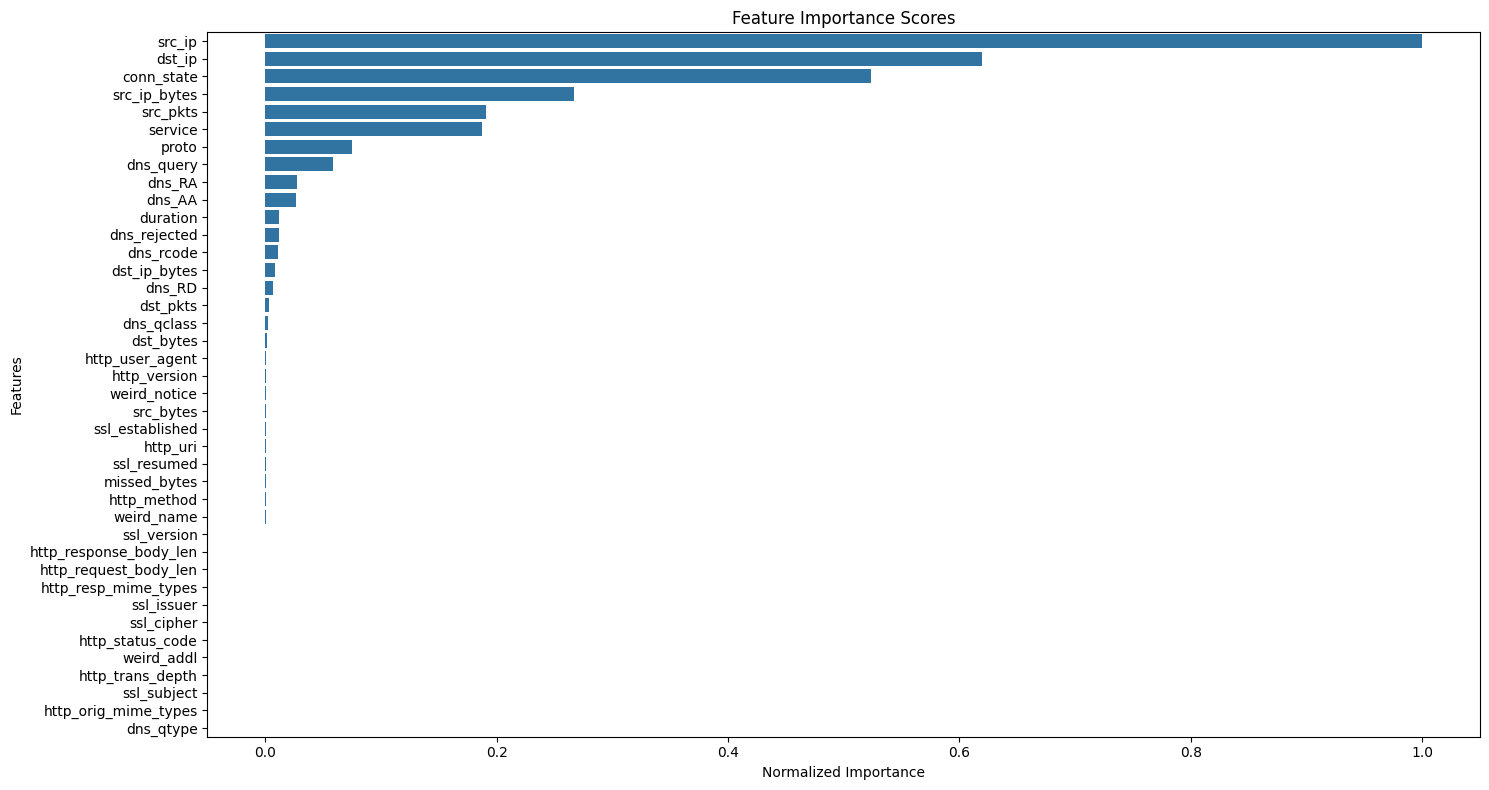

In [23]:
def calculate_feature_importance(agent, X_test, y_test, num_permutations=10):
    """计算特征重要性
    
    Args:
        agent: 训练好的PPO agent
        X_test: 测试数据
        y_test: 测试标签
        num_permutations: 每个特征打乱的次数
    
    Returns:
        feature_importance: 特征重要性得分字典
    """
    # 获取原始性能
    agent.network.eval()
    with torch.no_grad():
        logits, _ = agent.network(X_test)
        baseline_preds = torch.argmax(logits, dim=-1)
        baseline_acc = (baseline_preds == y_test).float().mean().item()
    
    # 初始化特征重要性得分
    feature_names = CATEGORICAL_FIELDS + NUMERICAL_FIELDS
    importance_scores = {}
    
    # 对每个特征进行计算
    for idx, feature_name in enumerate(feature_names):
        total_impact = 0
        
        # 多次打乱以获得稳定结果
        for _ in range(num_permutations):
            # 复制测试数据
            X_permuted = X_test.clone()
            
            # 随机打乱该特征的值
            perm_idx = torch.randperm(len(X_test))
            X_permuted[:, idx] = X_test[perm_idx, idx]
            
            # 计算打乱后的性能
            with torch.no_grad():
                logits, _ = agent.network(X_permuted)
                preds = torch.argmax(logits, dim=-1)
                permuted_acc = (preds == y_test).float().mean().item()
            
            # 计算性能下降
            impact = baseline_acc - permuted_acc
            total_impact += impact
        
        # 取平均值作为特征重要性得分
        importance_scores[feature_name] = total_impact / num_permutations
    
    # 归一化特征重要性得分
    max_score = max(importance_scores.values())
    importance_scores = {k: v/max_score for k, v in importance_scores.items()}
    
    return importance_scores

def visualize_feature_importance(importance_scores):
    """可视化特征重要性"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 按重要性排序
    sorted_scores = dict(sorted(importance_scores.items(), 
                              key=lambda x: x[1], 
                              reverse=True))
    
    plt.figure(figsize=(15, 8))
    sns.barplot(x=list(sorted_scores.values()), 
                y=list(sorted_scores.keys()))
    plt.title('Feature Importance Scores')
    plt.xlabel('Normalized Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

# 使用示例
importance_scores = calculate_feature_importance(agent, X_test, y_test)

# 打印最重要的10个特征
print("\nTop 10 Most Important Features:")
sorted_features = sorted(importance_scores.items(), 
                       key=lambda x: x[1], 
                       reverse=True)[:10]
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# 可视化
visualize_feature_importance(importance_scores)